## Updates 18 Oct Monday: 

### Try saving the FITS file by editing the header, or we can extract the science data as a csv and work off that for Pset 6. / continue below this pset's content, with printouts minimized. 


#### 1. Silicon band gap is larger than energies of most infrared photons. 
Silicon has a bandgap of 1.12 eV so photons need to have energies greater than this to excite an electron in the semiconductor from the valence to conduction band, generating a digital record. Infrared photons, of the order about 2000 nm, have about 0.6 eV which is insufficient to excite the electron (using E = h * f, where h is Planck's constant at 4.135E-15 eVs and f = 3E8/2E-6). Hence in general Silicon-based CCDs are not not sensitive to infrared photons. 

#### 2. At least 5 bits are needed to fully encode this information.
Since 2^4 = 16 and 2^5 = 32, with 20 possible values (from the 20 electrons) we need to choose 5 bits or more in the Analog-to-Digital Converter. If only 4 or fewer bits are used, then some electron state readings must either be assigned the same output or discarded, losing information. 


#### 3. Examine the science data

Examining two science images, the following telescope/CCD noise features were identified:

- Presence of overscan as dark edges at the extreme right and bottom of the image
- Bias structure (faint, horizontal black lines) 
- Saturated star blooming appearing as large bright circles
- Bad column as a white vertical line

The overscan region can be taken as lasting from pixel 570 onwards to 639 (right edge) and 0 to 119 (bottom edge). 


#### 4. Examine the dark frames

From the dark frame header, the two dark frames are for 10 and 180 seconds. The science exposure time is 180 seconds whereas the flat frame exposure time is 10 seconds. Hence to subtract the dark from the science image, the 180 seconds version of dark frame will be used. 

#### 5. Examine the flat field

There are a few stars in the flat field and visible dust donuts. Overall it is bright and quite uniform. 

In [1]:
# import headers
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
#import img_scale    # see if this is needed for pset 5

#### Helper functions for improved readability

Functions to help calculate data reduction process

In [19]:
def show_picture(data, low, high):
    """Shows a picture between 1st and 99th percentiles of 
    input data set, using plt"""
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(data, origin = 'lower', cmap = 'gray_r', \
           vmin = np.percentile(data, low), \
           vmax = np.percentile(data, high))
    plt.axis('off')
    plt.colorbar()
    return

def make_histogram(data):
    """Plot a histogram from data"""
    hist = plt.hist((data).flatten(), color = 'k')
    plt.xscale('linear')
    plt.yscale('log')
    #plt.axvline(np.percentile(data, 1), ls = ':', color = 'blue')
    plt.axvline(np.percentile(data, 99), ls = '--', color = 'red')
    return hist

def get_average(data):
    """Gets mean of data set (array of array)"""
    row_norms = []
    for row in data:
        # append norm from linear algebra package
        row_norms.append(np.mean(row))
    return np.mean(row_norms)

#### 6 & 7. Subtract the overscan and normalize flat field

Flat field normalization function

In [20]:
# need to read dark first, subtract in flat field
dark = fits.open('dark_180.C22.fits')
dark10 = fits.open('dark_10.C22.fits')

dark.info()
header_dark = dark[0].header

data_dark = dark[0].data.copy()
data_dark10 = dark10[0].data.copy()

Filename: dark_180.C22.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   (640, 2400)   float32   


In [21]:
def normalize_flat_field(image_name):
    """Function to do steps 6 and 7, with helper functions defined above
    image_name is a string
    Returns normalized flat image data (array of arrays)"""

    try:
        this_flat = fits.open(image_name)
    except:
        print("Error: file not located. Please check directory.")
        return
    
    this_flat.info()
    header_flat = this_flat[0].header
    print()
    
    data_flat = this_flat[0].data.copy()
    
    print("Original image above, corrected image without overscan below.")
    show_picture(data_flat,1,99)

    data_flat = data_flat[120:,:570] 

    show_picture(data_flat,1,99)   # overscan removed
    
    # NEW added 19 Oct
    data_flat = data_flat - data_dark10[120:,:570]  # remove dark
    
    data_flat = data_flat/get_average(data_flat) # normalize
    return data_flat

#### Actual computation of overscan subtraction:

Filename: 20130911095457m.C22_flat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   (640, 2400)   float32   

Original image above, corrected image without overscan below.
Filename: 20130911095548m.C22_flat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   (640, 2400)   float32   

Original image above, corrected image without overscan below.
Filename: 20130911095732m.C22_flat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   (640, 2400)   float32   

Original image above, corrected image without overscan below.
Filename: 20130911095641m.C22_flat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   (640, 2400)   float32   

Original image above, corrected image without overscan below.
Filename: 20130911095822m.C22_flat.fits
No.    Name      Ver    Type    

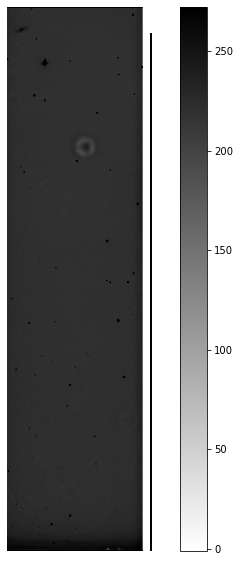

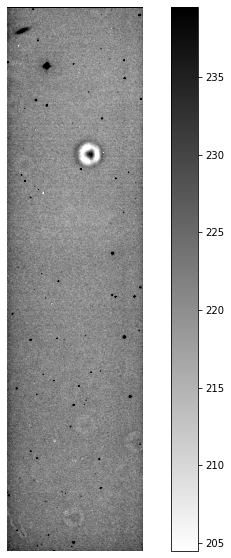

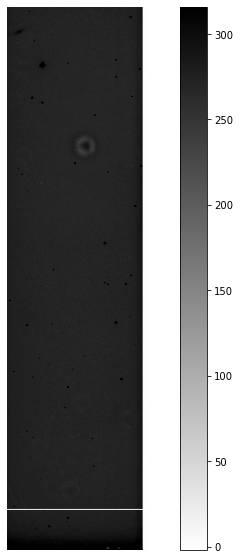

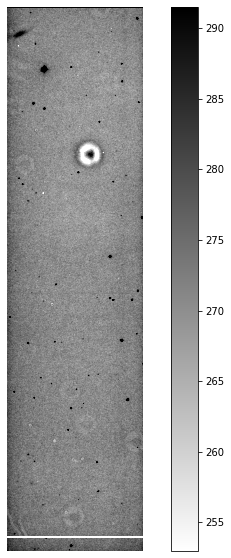

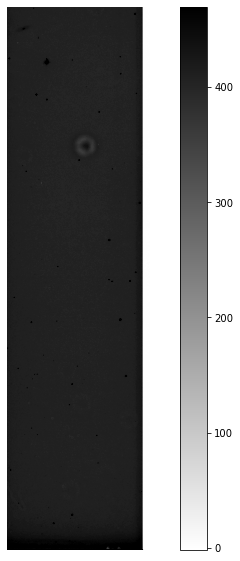

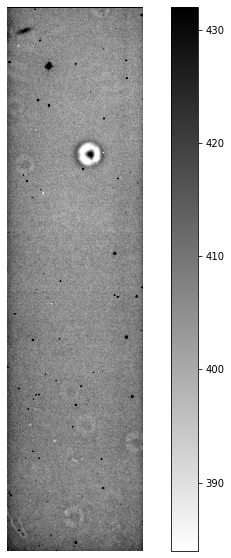

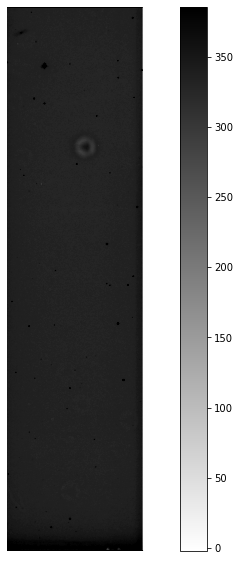

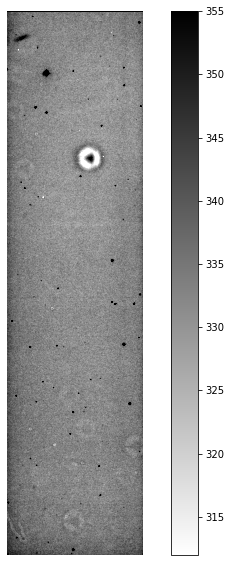

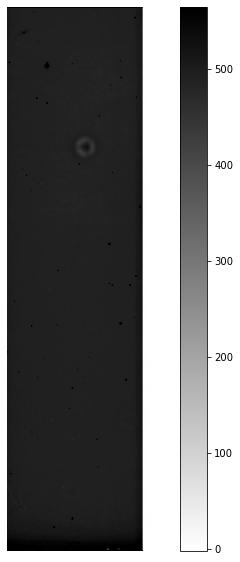

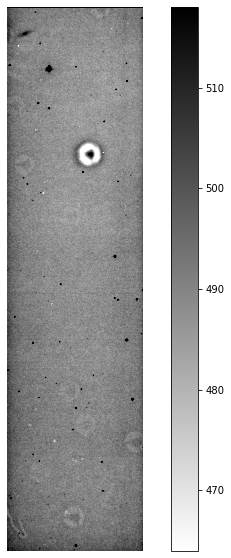

In [22]:
flats_list = {'20130911095457m.C22_flat.fits':[], '20130911095548m.C22_flat.fits':[],\
             '20130911095732m.C22_flat.fits':[], '20130911095641m.C22_flat.fits':[],\
             '20130911095822m.C22_flat.fits':[]}

for flat in flats_list:    # append data to dictionary
    flats_list[flat] = normalize_flat_field(flat)

(2280, 570)
The new image mean is 1.0


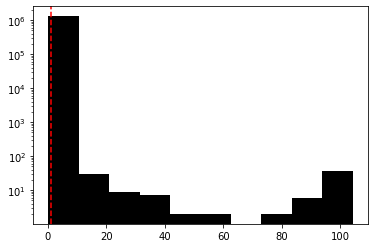

In [23]:
print(flats_list['20130911095457m.C22_flat.fits'].shape)

make_histogram(flats_list['20130911095457m.C22_flat.fits'])
print("The new image mean is", \
      round(get_average(flats_list['20130911095457m.C22_flat.fits']),3))    

For the overscan, between the individual flats there is a tiny variation on the order of a few pixels where the pixel value decreases significantly (overscan). However, in order to use median combine and set the science image later, we use a consistent cutoff at 120: and :570 for the vertical and horizontal dimensions respectively for all flats. 

Observe the pixel values (horizontal axes) have decreased significantly, with the mean of image equal to 1. The normalization step is necessary so that we can devide the bias/dark corrected science frame later by the normalized flat field for the science image; otherwise, the division would result in disproportionate final pixel values for the science image. 

#### 8. Combine the flat fields

Median combine works by taking the median value for each pixel out of the five available flat frame images, across the image rows and columns. Using the medium is preferable to the average we want to "skip over" the stars completely rather than include them in the flat image pixel calculation. Since the flat frames should have slightly different views of the sky, taking the median will then remove the stars' pixel values from affecting the background sky value. 

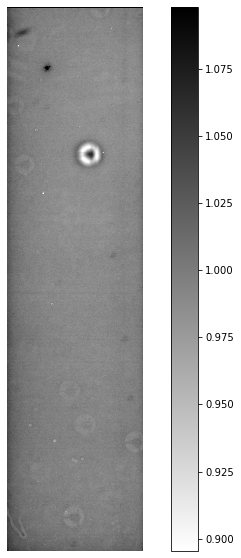

In [24]:
# print(np.median([[1,2,3],[4,-1,6],[10,11,12]],axis = 0))

combined_flat = []     # transfer to a new array
for row_count in range(2280):
    all_flat_array = []
    for flat in flats_list:
        all_flat_array.append(flats_list[flat][row_count])
    row_median = np.median(all_flat_array, axis = 0)
    combined_flat.append(row_median)
    
show_picture(combined_flat,0.1,99.9)

Comparing the final combined flat image above to the individual flats, we note that first the pixel values have dereased in magnitude (so as to fit the normalization). The combined flat image shows fewer distinct stars (the small black dots) compared to the individual image, showing the effects of the median calculation in generating a representative sky value. 

#### 9. Dark Subtraction and Flat Fielding

Science data processing with overscan, dark and flat field corrections



In [25]:
science_dict = {'20130910234901s.C22_science.fits': [],
'20130911040543s.C22_science.fits': [],
'20130911020246s.C22_science.fits': []}

original_science_sample = fits.open('20130910234901s.C22_science.fits')[0].data.copy()

def science_processing(science):
    """Science processing function, where science input is file string name
    Returns corrected science image"""

    this_science = fits.open(science)
    header_science = this_science[0].header
    data_science = this_science[0].data   
    original_science_sample = data_science.copy()
    show_picture(data_science,1,99)   # Original
    
    data_science = data_science[120:,:570]   # remove overscan

    data_science = data_science - data_dark[120:,:570]  # remove dark

    for row_idx in range(len(combined_flat)):
        for column_idx in range(len(combined_flat[row_idx])):
            data_science[row_idx][column_idx] /= combined_flat[row_idx][column_idx]
    show_picture(data_science,1,99)
        
    return data_science  

Actual computation for science images and combining to form median

Original science image above, overscan and dark corrected below


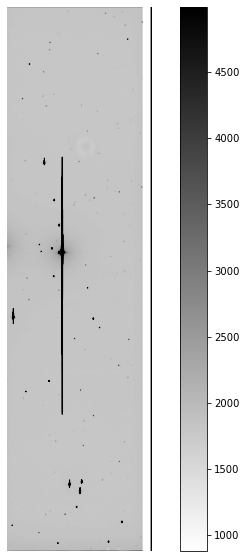

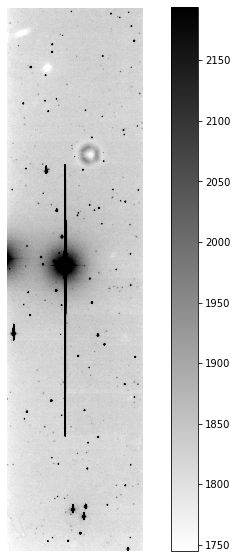

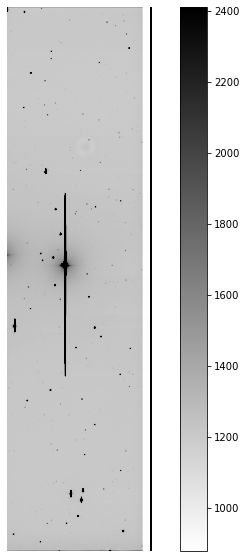

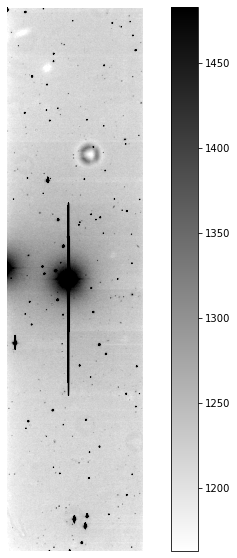

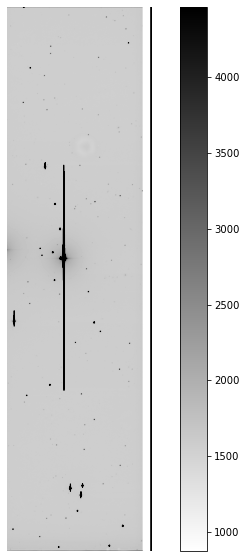

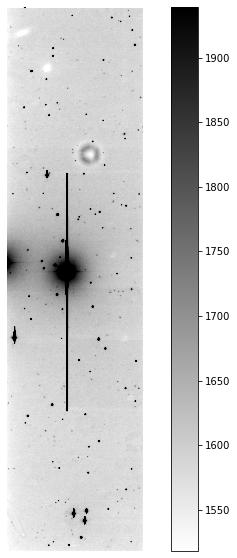

In [26]:
print("Original science image above, overscan and dark corrected below")
for science in science_dict:    # append data to dictionary
    science_dict[science] = science_processing(science)

#combined_science = []     # transfer to a new array
#for row_count in range(2280):
#    all_science_array = []
#    for science in science_dict:
#        all_science_array.append(science_dict[science][row_count])
#    row_median = np.median(all_science_array, axis = 0)
#    combined_science.append(row_median)


AttributeError: 'tuple' object has no attribute 'argmax'

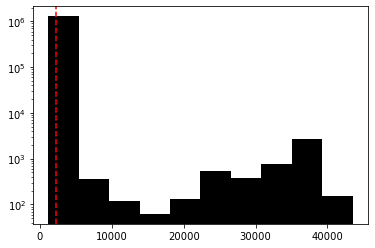

In [27]:
# Sky Subtract

hist = make_histogram(science_dict['20130910234901s.C22_science.fits'])

mode_index = hist.argmax()



#### Display final science output

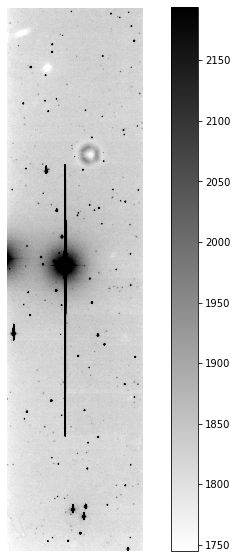

In [16]:
show_picture(science_dict['20130910234901s.C22_science.fits'],1,99)
# don't combine before aligning

The dust donut in the center right region (above the saturated star) has been partially mitigated after applying the flat field correction. A hot pixel in the upper left corner (visible by blinking between the flat field, approx. at (50, 2000)) is also removed in the final science image. Compared to the initial science image, the final median combined science image has more stars visible (displayed using the same show() function), with the star saturation streak decreased.

#### Science image before/after from 2 to 98 percentile
Original image above, final below. The stars stand out more against the background and the dust donut is corrected. 

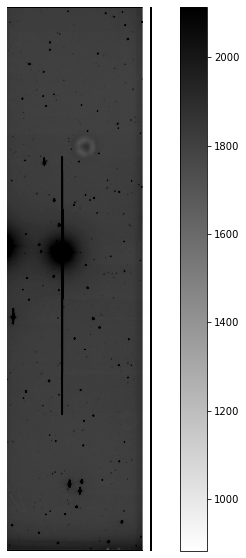

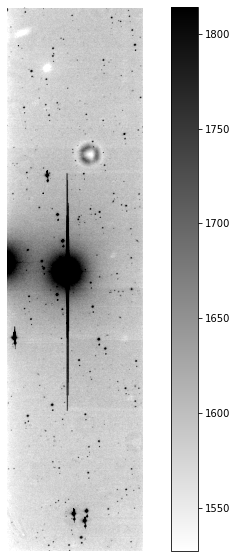

In [11]:
show_picture(original_science_sample,2,98)

show_picture(combined_science,2,98)

#### Check headers

In [12]:
# flat frame header
sample_flat = fits.open('20130911095548m.C22_flat.fits')
#sample_flat[0].header

In [13]:
#header_dark

In [14]:
science = fits.open('20130910234901s.C22_science.fits')
#science[0].header